X = [[  5.6989006   -0.37893937]
 [ -3.32513059 -10.68245311]
 [ -5.44392498 -10.08497827]
 [  4.02385069  12.98556471]
 [  4.54813259   7.29128896]
 [  8.66082951  10.8354449 ]
 [  5.60875008   3.49165925]
 [ -4.05611128 -10.11820741]
 [  6.81635295  -0.57030908]
 [ 10.06034231  12.67764768]]
Y = [1 2 2 0 0 0 1 2 1 0]


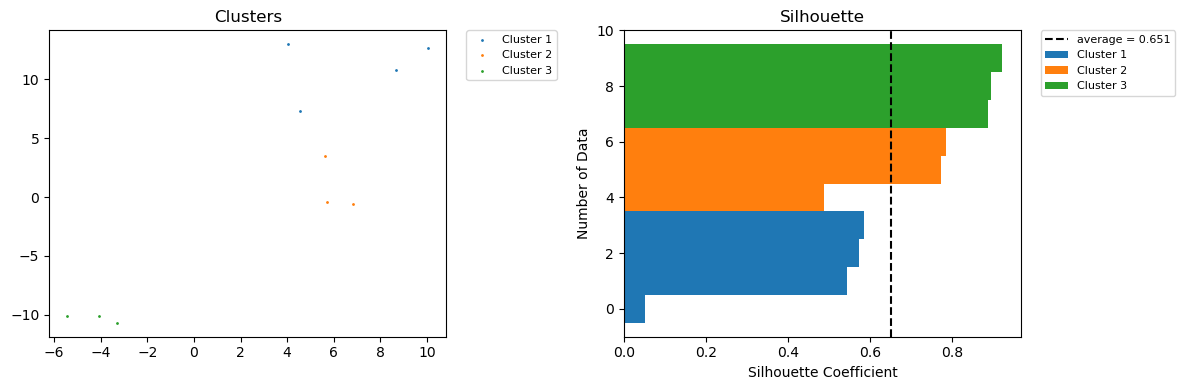

In [1]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
import numpy as np



def calc_silhouette(data, clusters):
    """
    クラスタリングのシルエット係数の計算
    
    Parameters
    ----------
    data :
        データサンプル
    clusters :
        各データサンプルが属するクラスタ
    """
    n = len(data)
    num_clusters = len(np.unique(clusters))
    cl_ids = []
    centroids = []
    for c in range(num_clusters):
        ids = np.where(clusters == c)[0]
        cl_ids.append(ids)
        centroids.append(np.average(data[ids], axis=0))
    silhouette = np.zeros(n)
    for c in range(num_clusters):
        for i in cl_ids[c]:
            nearest_clusters = np.argsort(np.sum((data[i]-centroids)**2, axis=1))
            c_nearest = nearest_clusters[1] if nearest_clusters[0]==c else nearest_clusters[0]
            a = np.sum(np.sqrt(np.sum((data[i]-data[cl_ids[c]])**2, axis=1))) / (len(cl_ids[c])-1)
            b = np.average(np.sqrt(np.sum((data[i]-data[cl_ids[c_nearest]])**2, axis=1)))
            silhouette[i] = (b-a) / max(a, b)
    return silhouette


def plot_silhouette(data, clusters):
    """
    シルエット係数を計算・描画
    """
    cl_size = {}
    for c in np.unique(clusters):
        cl_size[c] = np.count_nonzero(clusters == c)
    silhouette = calc_silhouette(data, clusters)
    silhouette_ave = np.average(silhouette)
    ids_sorted = np.lexsort((silhouette, clusters))
    data_sorted = data[ids_sorted]
    silhouette_sorted = silhouette[ids_sorted]
    
    plt.figure(figsize=(12, 4))
    # クラスタの描画
    plt.subplot(1, 2, 1)
    plt.title('Clusters')
    start = 0
    for c in range(len(cl_size)):
        plt.scatter(data_sorted[start:start+cl_size[c], 0], data_sorted[start:start+cl_size[c], 1], s=1.0, label='Cluster {}'.format(c+1))
        start += cl_size[c]
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8)
    plt.tight_layout()
    # シルエット図の描画
    plt.subplot(1, 2, 2)
    plt.title('Silhouette')
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Number of Data')
    plt.axvline(silhouette_ave, c='black', linestyle='dashed', label='average = {:.3f}'.format(silhouette_ave))
    start = 0
    for c in range(len(cl_size)):
        plt.barh(range(start, start+cl_size[c]), silhouette_sorted[start:start+cl_size[c]], height=1.0, label='Cluster {}'.format(c+1))
        start += cl_size[c]
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8)
    plt.tight_layout()
    plt.savefig('figures/SVD-UMAP_HumanES_Chu_EEI_merge_ratio_p1000_40c_50n_silhouette_5.png')
    plt.show()


def main():
    
    X, Y = make_blobs(random_state=8,
                  n_samples=10, 
                  n_features=2, 
                  cluster_std=1.5,
                  centers=3)

    print("X =", X)
    print("Y =", Y)

    plot_silhouette(X, Y)

if __name__ == '__main__':
    main()

/tmp/ipykernel_3118527/1738478500.py:133: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  main()


1018
1018
['DEC_Batch', 'HFF_Batch', 'NPC_Batch', 'EC_Batch', 'TB_Batch', 'H9_Batch', 'H1_Exp']
1018
(20097, 1018)


<Figure size 4200x4200 with 0 Axes>

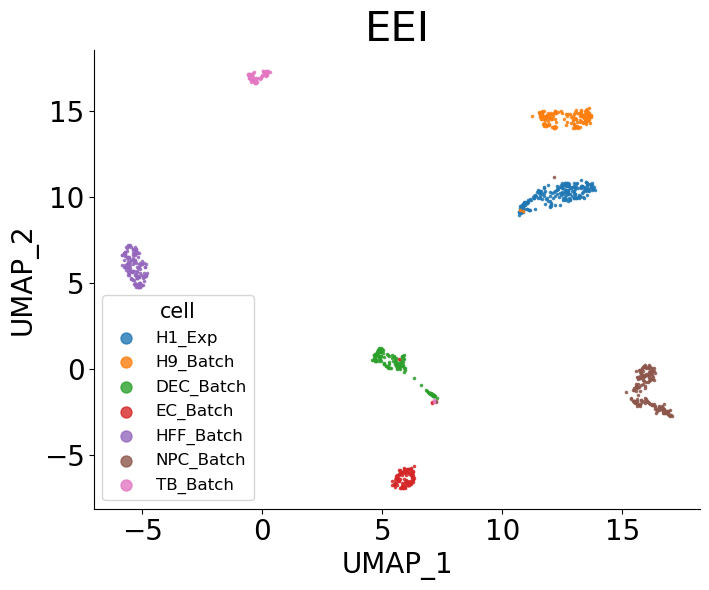

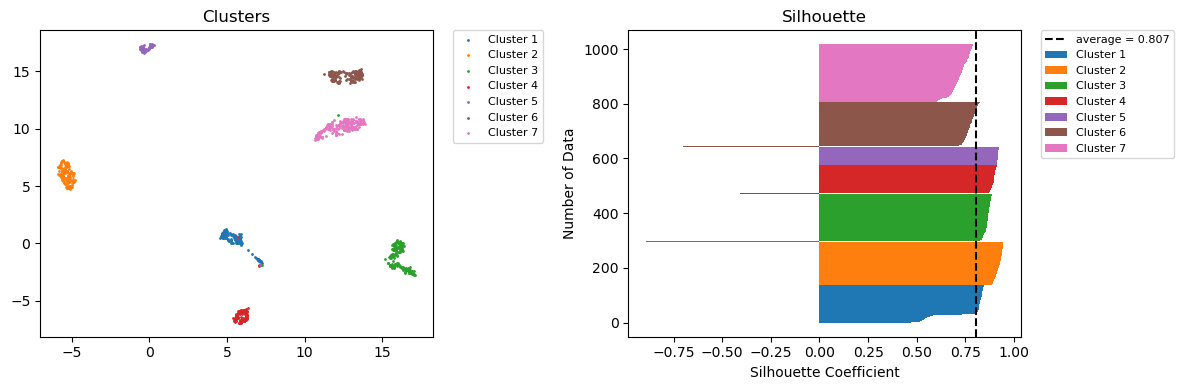

In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# 主成分分析(PCA)→tSNE を行うプログラム

import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import umap.umap_ as umap
from scipy.sparse.csgraph import connected_components
from sklearn import datasets
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import seaborn as sns
import csv
import os
import collections 
#import silhouette


def main():
   
    labels = []
    #input_data1 = pd.read_csv("HumanES_EEI_feature_ratio_matrix_5000pair.csv", index_col=0)
    #input_data1 = pd.read_csv("GSE76381_ESMoleculeCounts.cef.txt", index_col=0, sep="\t")
    input_data1 = pd.read_csv("Data_2021_NatsuNakajima/FigS2/A/raw/HumanES_Chu_EEI_feature_merge_matrix_1000pair.csv", index_col=0)
    labels = input_data1.columns
    COL = np.array(labels)
    print(len(COL))
    A = pd.Series(COL)
    DEL = A.str.strip("_"".""0""1""2""3""4""5""6""7""8""9")

    input_data1.columns = DEL
    DEL_list = DEL.values.tolist()
    print(len(DEL_list))
    DEL_string = " ".join(DEL_list)
    DEL_unique = list(set(DEL_list))
    print(DEL_unique)
    count = 0
    for d in DEL_unique:
       DEL_string = DEL_string.replace(d, str(count))
       count += 1
       
    DEL_num = DEL_string.split(' ')
    print(len(DEL_num))
    DEL_num = [int(s) for s in DEL_num]
    DEL_num = np.array(DEL_num)
    
    #print(input_data1.columns)
    NEW_A = np.array(input_data1)
    Allgene = NEW_A.shape[0]
    Allsample = NEW_A.shape[1]
    print(NEW_A.shape)

     # Normalizationを行う
    
    #Norm_read = np.zeros((Allgene, Allsample), dtype=np.float64)
    #sum_UMI = []
    #for s in range(0, Allsample):
    #   sum_umi = 0.0
    #   for i in range(0, Allgene):
    #      sum_umi += float(NEW_A[i][s])
    #   sum_UMI.append(sum_umi)
       #print (sum_UMI[s])

    #for s in range(0, Allsample):
    #   for i in range(0, Allgene):
    #      Norm_read[i][s] = (float(NEW_A[i][s]) / sum_UMI[s])*10000
    #print (Norm_read[i][s])         

    #Log_A = np.log1p(Norm_read)
    #Log_A = np.log1p(NEW_A)
    #print(Log_A)
   
    # 主成分分析する
    #pca = PCA(n_components=20)
    #pca.fit(NEW_A.T)
    # 分析結果を元にデータセットを主成分に変換する
    #transformed = pca.fit_transform(NEW_A.T)

    # perform SVD
    model_svd = TruncatedSVD(n_components=40)
    vecs_list = model_svd.fit_transform(NEW_A.T)

    # 削減した10次元データを、さらにtSNEにかけてみる
    #model = TSNE(n_components=2, perplexity=20, n_iter=20000, verbose=1, random_state=10)
    #tsne = model.fit_transform(transformed)
    #tsne = model.fit_transform(vecs_list)

    # Perform UMAP for 20-dimensitonal data
    model_umap = umap.UMAP(n_components=2,n_neighbors=50)
    UMAP = model_umap.fit_transform(vecs_list)
    #print(DEL_list)
    
    df = pd.DataFrame({ 'UMAP_1' : UMAP[:,0], 'UMAP_2' : UMAP[:,1], 'cell' : input_data1.columns})
    df.head()

    plt.figure(figsize=(7, 7), dpi=600)
    #sns.lmplot(x="tSNE_1", y="tSNE_2", data=df, hue="cell", fit_reg=False, legend=True, markers=".", size=5)
    #sns.lmplot(x="UMAP_1", y="UMAP_2", data=df, hue="cell", fit_reg=False, legend=True, scatter_kws={"marker": ".", "s": 0.8})
    sns.lmplot(x="UMAP_1", y="UMAP_2", data=df, hue='cell', fit_reg=False, legend=False, scatter_kws={"marker": ".", "s": 2.5}, height=6, aspect=1.2)
    ax = plt.gca()
    ax.legend(title_fontsize=15,markerscale=5,title="cell", fontsize=12, loc="best")
    ax.set_title("EEI", fontsize=30)
    xl = ax.get_xlabel()
    ax.set_xlabel(xl, fontsize=20)
    yl = ax.get_ylabel()
    ax.set_ylabel(yl, fontsize=20)
    ax.tick_params(labelsize=20)
    plt.tight_layout()
    
    plt.savefig('figures/SVD-UMAP_HumanES_Chu_EEI_merge_ratio_legend_p1000_40c_50n.png')
    
    # silhouette.plot_silhouette(UMAP, DEL_num)
    plot_silhouette(UMAP, DEL_num)


    # 主成分の寄与率を出力する
    #print('各次元の寄与率: {0}'.format(pca.explained_variance_ratio_))
    #print('累積寄与率: {0}'.format(sum(pca.explained_variance_ratio_)))
    
         # グラフを表示して保存
    #plt.savefig('PCA-tSNE_human_ES_EEI_ratio_feature.png')
    #plt.savefig('SVD-UMAP_human_ES_EEI_ratio_feature_5000pair_40c_50n.png')
    #plt.savefig('SVD-UMAP_human_ES_raw_40c_50n.png')
    #plt.savefig('SVD-UMAP_HumanES_Manno_EEI_merge_ratio_p1000_40c_50n.png')
    #plt.show()



if __name__ == '__main__':
    main()


/tmp/ipykernel_3118527/719272182.py:171: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  main()


1018
1018
['DEC_Batch', 'HFF_Batch', 'NPC_Batch', 'EC_Batch', 'TB_Batch', 'H9_Batch', 'H1_Exp']
1018
(20097, 1018)


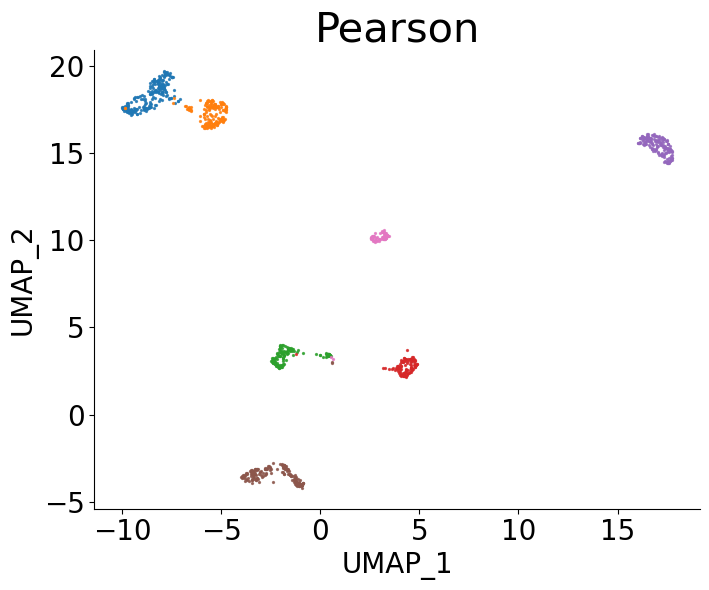

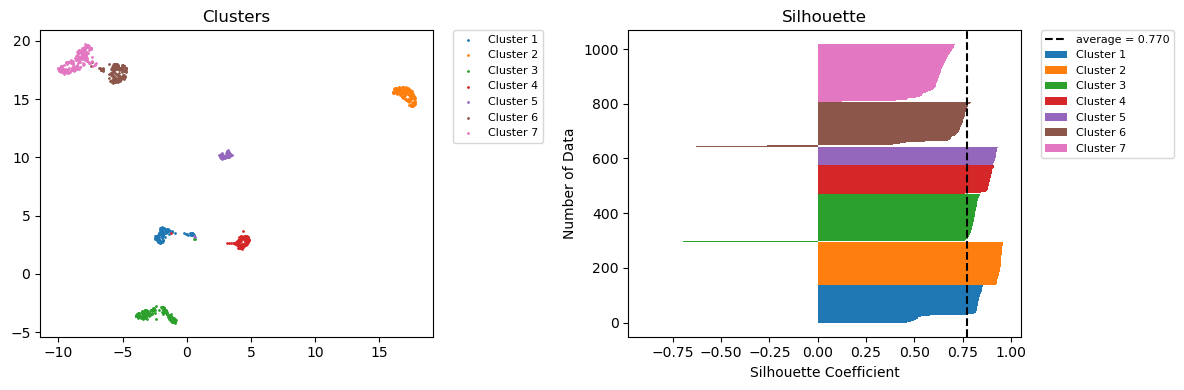

In [6]:
# Pearson

def plot_silhouette(data, clusters):
    """
    シルエット係数を計算・描画
    """
    cl_size = {}
    for c in np.unique(clusters):
        cl_size[c] = np.count_nonzero(clusters == c)
    silhouette = calc_silhouette(data, clusters)
    silhouette_ave = np.average(silhouette)
    ids_sorted = np.lexsort((silhouette, clusters))
    data_sorted = data[ids_sorted]
    silhouette_sorted = silhouette[ids_sorted]
    
    plt.figure(figsize=(12, 4))
    # クラスタの描画
    plt.subplot(1, 2, 1)
    plt.title('Clusters')
    start = 0
    for c in range(len(cl_size)):
        plt.scatter(data_sorted[start:start+cl_size[c], 0], data_sorted[start:start+cl_size[c], 1], s=1.0, label='Cluster {}'.format(c+1))
        start += cl_size[c]
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8)
    plt.tight_layout()
    # シルエット図の描画
    plt.subplot(1, 2, 2)
    plt.title('Silhouette')
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Number of Data')
    plt.axvline(silhouette_ave, c='black', linestyle='dashed', label='average = {:.3f}'.format(silhouette_ave))
    start = 0
    for c in range(len(cl_size)):
        plt.barh(range(start, start+cl_size[c]), silhouette_sorted[start:start+cl_size[c]], height=1.0, label='Cluster {}'.format(c+1))
        start += cl_size[c]
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8)
    plt.tight_layout()
    plt.savefig('figures/SVD-UMAP_HumanES_Chu_PEARSON_merge_ratio_p1000_40c_50n_silhouette.png')
    plt.show()
    
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# 主成分分析(PCA)→tSNE を行うプログラム

import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import umap.umap_ as umap
from scipy.sparse.csgraph import connected_components
from sklearn import datasets
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import seaborn as sns
import csv
import os
import collections 
import silhouette


def main():
   
    labels = []
    #input_data1 = pd.read_csv("HumanES_EEI_feature_ratio_matrix_5000pair.csv", index_col=0)
    #input_data1 = pd.read_csv("GSE76381_ESMoleculeCounts.cef.txt", index_col=0, sep="\t")
    input_data1 = pd.read_csv("Data_2021_NatsuNakajima/FigS2/A/raw/HumanES_Chu_PEARSON_feature_merge_matrix_1000pair.csv", index_col=0)
    labels = input_data1.columns
    COL = np.array(labels)
    print(len(COL))
    A = pd.Series(COL)
    DEL = A.str.strip("_"".""0""1""2""3""4""5""6""7""8""9")

    input_data1.columns = DEL
    DEL_list = DEL.values.tolist()
    print(len(DEL_list))
    DEL_string = " ".join(DEL_list)
    DEL_unique = list(set(DEL_list))
    print(DEL_unique)
    count = 0
    for d in DEL_unique:
       DEL_string = DEL_string.replace(d, str(count))
       count += 1
       
    DEL_num = DEL_string.split(' ')
    print(len(DEL_num))
    DEL_num = [int(s) for s in DEL_num]
    DEL_num = np.array(DEL_num)
    
    #print(input_data1.columns)
    NEW_A = np.array(input_data1)
    Allgene = NEW_A.shape[0]
    Allsample = NEW_A.shape[1]
    print(NEW_A.shape)

     # Normalizationを行う
    
    #Norm_read = np.zeros((Allgene, Allsample), dtype=np.float64)
    #sum_UMI = []
    #for s in range(0, Allsample):
    #   sum_umi = 0.0
    #   for i in range(0, Allgene):
    #      sum_umi += float(NEW_A[i][s])
    #   sum_UMI.append(sum_umi)
       #print (sum_UMI[s])

    #for s in range(0, Allsample):
    #   for i in range(0, Allgene):
    #      Norm_read[i][s] = (float(NEW_A[i][s]) / sum_UMI[s])*10000
    #print (Norm_read[i][s])         

    #Log_A = np.log1p(Norm_read)
    #Log_A = np.log1p(NEW_A)
    #print(Log_A)
   
    # 主成分分析する
    #pca = PCA(n_components=20)
    #pca.fit(NEW_A.T)
    # 分析結果を元にデータセットを主成分に変換する
    #transformed = pca.fit_transform(NEW_A.T)

    # perform SVD
    model_svd = TruncatedSVD(n_components=40)
    vecs_list = model_svd.fit_transform(NEW_A.T)

    # 削減した10次元データを、さらにtSNEにかけてみる
    #model = TSNE(n_components=2, perplexity=20, n_iter=20000, verbose=1, random_state=10)
    #tsne = model.fit_transform(transformed)
    #tsne = model.fit_transform(vecs_list)

    # Perform UMAP for 20-dimensitonal data
    model_umap = umap.UMAP(n_components=2,n_neighbors=50)
    UMAP = model_umap.fit_transform(vecs_list)
    #print(DEL_list)
    
    df = pd.DataFrame({ 'UMAP_1' : UMAP[:,0], 'UMAP_2' : UMAP[:,1], 'cell' : input_data1.columns})
    df.head()

    #sns.lmplot(x="tSNE_1", y="tSNE_2", data=df, hue="cell", fit_reg=False, legend=True, markers=".", size=5)
    #sns.lmplot(x="UMAP_1", y="UMAP_2", data=df, hue="cell", fit_reg=False, legend=True, scatter_kws={"marker": ".", "s": 0.8})
    sns.lmplot(x="UMAP_1", y="UMAP_2", data=df, hue='cell', fit_reg=False, legend=False, scatter_kws={"marker": ".", "s": 1.8}, height=6, aspect=1.2)
    ax = plt.gca()
    #ax.legend(title_fontsize=13,markerscale=4,title="cell", fontsize=10, loc="best")
    ax.set_title("Pearson", fontsize=30)
    xl = ax.get_xlabel()
    ax.set_xlabel(xl, fontsize=20)
    yl = ax.get_ylabel()
    ax.set_ylabel(yl, fontsize=20)
    ax.tick_params(labelsize=20)
    plt.tight_layout()
    plt.savefig('figures/SVD-UMAP_HumanES_Chu_PEARSON_merge_ratio_p1000_40c_50n.png')
    
#    silhouette.plot_silhouette(UMAP, DEL_num)
    plot_silhouette(UMAP, DEL_num)


    # 主成分の寄与率を出力する
    #print('各次元の寄与率: {0}'.format(pca.explained_variance_ratio_))
    #print('累積寄与率: {0}'.format(sum(pca.explained_variance_ratio_)))
    
         # グラフを表示して保存
    #plt.savefig('PCA-tSNE_human_ES_EEI_ratio_feature.png')
    #plt.savefig('SVD-UMAP_human_ES_EEI_ratio_feature_5000pair_40c_50n.png')
    #plt.savefig('SVD-UMAP_human_ES_raw_40c_50n.png')
    #plt.savefig('SVD-UMAP_HumanES_Manno_EEI_merge_ratio_p1000_40c_50n.png')
    #plt.show()



if __name__ == '__main__':
    main()

/tmp/ipykernel_3118527/2343642514.py:172: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  main()


1018
1018
['DEC_Batch', 'HFF_Batch', 'NPC_Batch', 'EC_Batch', 'TB_Batch', 'H9_Batch', 'H1_Exp']
1018
(20097, 1018)


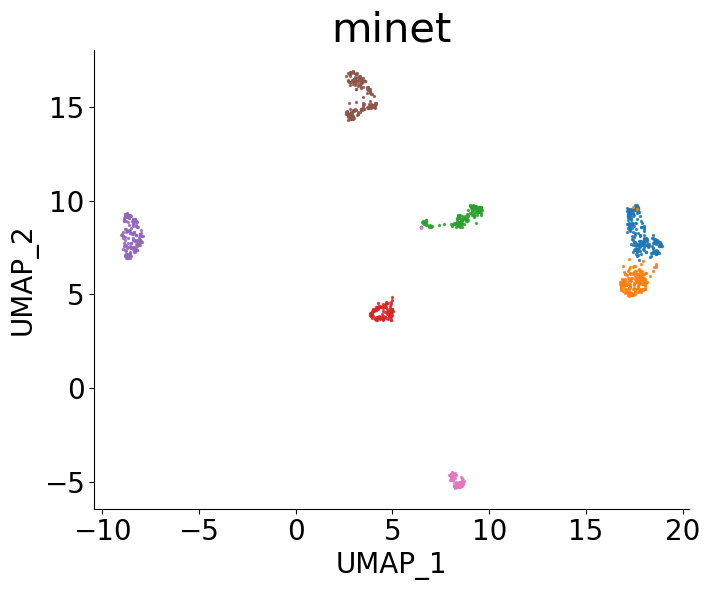

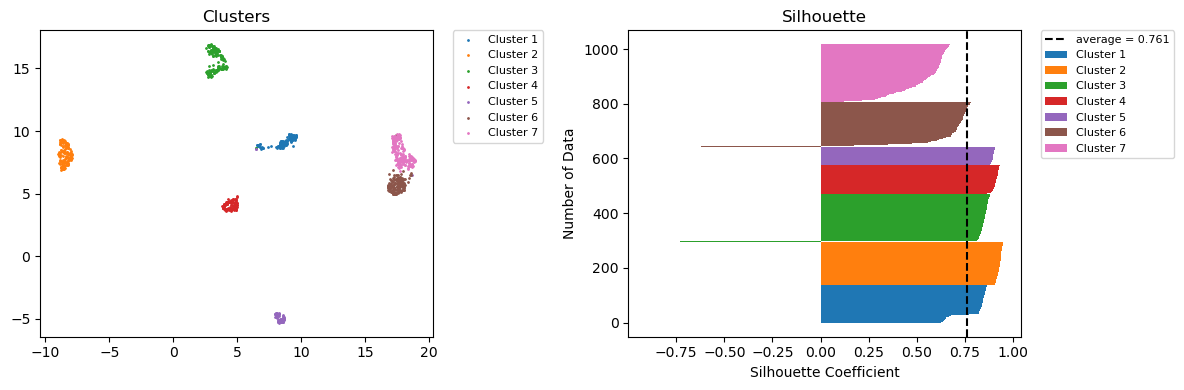

In [8]:
# minet

def plot_silhouette(data, clusters):
    """
    シルエット係数を計算・描画
    """
    cl_size = {}
    for c in np.unique(clusters):
        cl_size[c] = np.count_nonzero(clusters == c)
    silhouette = calc_silhouette(data, clusters)
    silhouette_ave = np.average(silhouette)
    ids_sorted = np.lexsort((silhouette, clusters))
    data_sorted = data[ids_sorted]
    silhouette_sorted = silhouette[ids_sorted]
    
    plt.figure(figsize=(12, 4))
    # クラスタの描画
    plt.subplot(1, 2, 1)
    plt.title('Clusters')
    start = 0
    for c in range(len(cl_size)):
        plt.scatter(data_sorted[start:start+cl_size[c], 0], data_sorted[start:start+cl_size[c], 1], s=1.0, label='Cluster {}'.format(c+1))
        start += cl_size[c]
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8)
    plt.tight_layout()
    # シルエット図の描画
    plt.subplot(1, 2, 2)
    plt.title('Silhouette')
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Number of Data')
    plt.axvline(silhouette_ave, c='black', linestyle='dashed', label='average = {:.3f}'.format(silhouette_ave))
    start = 0
    for c in range(len(cl_size)):
        plt.barh(range(start, start+cl_size[c]), silhouette_sorted[start:start+cl_size[c]], height=1.0, label='Cluster {}'.format(c+1))
        start += cl_size[c]
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8)
    plt.tight_layout()
    plt.savefig('figures/SVD-UMAP_HumanES_Chu_minet_merge_ratio_p1000_40c_50n_silhouette.png')
    plt.show()
    
    
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# 主成分分析(PCA)→tSNE を行うプログラム

import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import umap.umap_ as umap
from scipy.sparse.csgraph import connected_components
from sklearn import datasets
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import seaborn as sns
import csv
import os
import collections 
import silhouette


def main():
   
    labels = []
    #input_data1 = pd.read_csv("HumanES_EEI_feature_ratio_matrix_5000pair.csv", index_col=0)
    #input_data1 = pd.read_csv("GSE76381_ESMoleculeCounts.cef.txt", index_col=0, sep="\t")
    input_data1 = pd.read_csv("Data_2021_NatsuNakajima/FigS2/A/raw/HumanES_Chu_minet_feature_merge_matrix_1000pair.csv", index_col=0)
    labels = input_data1.columns
    COL = np.array(labels)
    print(len(COL))
    A = pd.Series(COL)
    DEL = A.str.strip("_"".""0""1""2""3""4""5""6""7""8""9")

    input_data1.columns = DEL
    DEL_list = DEL.values.tolist()
    print(len(DEL_list))
    DEL_string = " ".join(DEL_list)
    DEL_unique = list(set(DEL_list))
    print(DEL_unique)
    count = 0
    for d in DEL_unique:
       DEL_string = DEL_string.replace(d, str(count))
       count += 1
       
    DEL_num = DEL_string.split(' ')
    print(len(DEL_num))
    DEL_num = [int(s) for s in DEL_num]
    DEL_num = np.array(DEL_num)
    
    #print(input_data1.columns)
    NEW_A = np.array(input_data1)
    Allgene = NEW_A.shape[0]
    Allsample = NEW_A.shape[1]
    print(NEW_A.shape)

     # Normalizationを行う
    
    #Norm_read = np.zeros((Allgene, Allsample), dtype=np.float64)
    #sum_UMI = []
    #for s in range(0, Allsample):
    #   sum_umi = 0.0
    #   for i in range(0, Allgene):
    #      sum_umi += float(NEW_A[i][s])
    #   sum_UMI.append(sum_umi)
       #print (sum_UMI[s])

    #for s in range(0, Allsample):
    #   for i in range(0, Allgene):
    #      Norm_read[i][s] = (float(NEW_A[i][s]) / sum_UMI[s])*10000
    #print (Norm_read[i][s])         

    #Log_A = np.log1p(Norm_read)
    #Log_A = np.log1p(NEW_A)
    #print(Log_A)
   
    # 主成分分析する
    #pca = PCA(n_components=20)
    #pca.fit(NEW_A.T)
    # 分析結果を元にデータセットを主成分に変換する
    #transformed = pca.fit_transform(NEW_A.T)

    # perform SVD
    model_svd = TruncatedSVD(n_components=40)
    vecs_list = model_svd.fit_transform(NEW_A.T)

    # 削減した10次元データを、さらにtSNEにかけてみる
    #model = TSNE(n_components=2, perplexity=20, n_iter=20000, verbose=1, random_state=10)
    #tsne = model.fit_transform(transformed)
    #tsne = model.fit_transform(vecs_list)

    # Perform UMAP for 20-dimensitonal data
    model_umap = umap.UMAP(n_components=2,n_neighbors=50)
    UMAP = model_umap.fit_transform(vecs_list)
    #print(DEL_list)
    
    df = pd.DataFrame({ 'UMAP_1' : UMAP[:,0], 'UMAP_2' : UMAP[:,1], 'cell' : input_data1.columns})
    df.head()

    #sns.lmplot(x="tSNE_1", y="tSNE_2", data=df, hue="cell", fit_reg=False, legend=True, markers=".", size=5)
    #sns.lmplot(x="UMAP_1", y="UMAP_2", data=df, hue="cell", fit_reg=False, legend=True, scatter_kws={"marker": ".", "s": 0.8})
    sns.lmplot(x="UMAP_1", y="UMAP_2", data=df, hue='cell', fit_reg=False, legend=False, scatter_kws={"marker": ".", "s": 1.8}, height=6, aspect=1.2)
    ax = plt.gca()
    #ax.legend(title_fontsize=13,markerscale=4,title="cell", fontsize=10, loc="best")
    ax.set_title("minet", fontsize=30)
    xl = ax.get_xlabel()
    ax.set_xlabel(xl, fontsize=20)
    yl = ax.get_ylabel()
    ax.set_ylabel(yl, fontsize=20)
    ax.tick_params(labelsize=20)
    plt.tight_layout()
    plt.savefig('figures/SVD-UMAP_HumanES_Chu_minet_merge_ratio_p1000_40c_50n.png')
    
    
    plot_silhouette(UMAP, DEL_num)


    # 主成分の寄与率を出力する
    #print('各次元の寄与率: {0}'.format(pca.explained_variance_ratio_))
    #print('累積寄与率: {0}'.format(sum(pca.explained_variance_ratio_)))
    
         # グラフを表示して保存
    #plt.savefig('PCA-tSNE_human_ES_EEI_ratio_feature.png')
    #plt.savefig('SVD-UMAP_human_ES_EEI_ratio_feature_5000pair_40c_50n.png')
    #plt.savefig('SVD-UMAP_human_ES_raw_40c_50n.png')
    #plt.savefig('SVD-UMAP_HumanES_Manno_EEI_merge_ratio_p1000_40c_50n.png')
    #plt.show()



if __name__ == '__main__':
    main()

/tmp/ipykernel_3118527/2177143987.py:171: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  main()


1018
1018
['DEC_Batch', 'HFF_Batch', 'NPC_Batch', 'EC_Batch', 'TB_Batch', 'H9_Batch', 'H1_Exp']
1018
(20097, 1018)


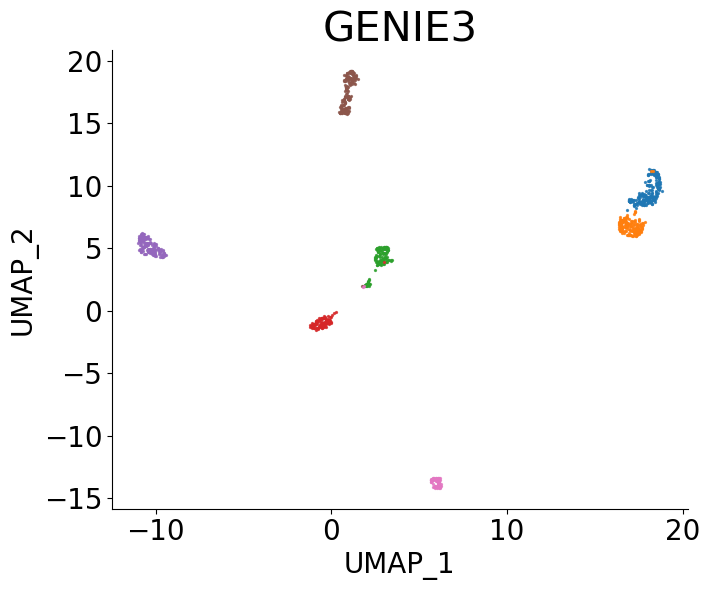

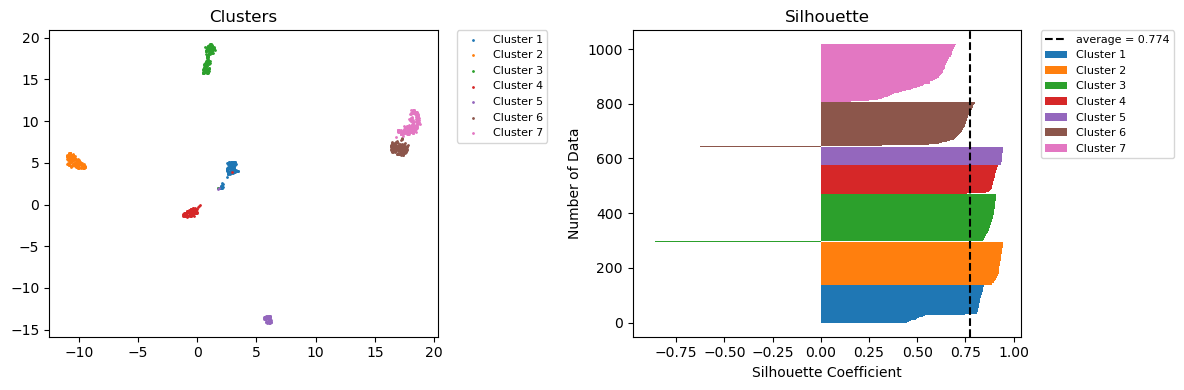

In [10]:
# GENIE3

def plot_silhouette(data, clusters):
    """
    シルエット係数を計算・描画
    """
    cl_size = {}
    for c in np.unique(clusters):
        cl_size[c] = np.count_nonzero(clusters == c)
    silhouette = calc_silhouette(data, clusters)
    silhouette_ave = np.average(silhouette)
    ids_sorted = np.lexsort((silhouette, clusters))
    data_sorted = data[ids_sorted]
    silhouette_sorted = silhouette[ids_sorted]
    
    plt.figure(figsize=(12, 4))
    # クラスタの描画
    plt.subplot(1, 2, 1)
    plt.title('Clusters')
    start = 0
    for c in range(len(cl_size)):
        plt.scatter(data_sorted[start:start+cl_size[c], 0], data_sorted[start:start+cl_size[c], 1], s=1.0, label='Cluster {}'.format(c+1))
        start += cl_size[c]
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8)
    plt.tight_layout()
    # シルエット図の描画
    plt.subplot(1, 2, 2)
    plt.title('Silhouette')
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Number of Data')
    plt.axvline(silhouette_ave, c='black', linestyle='dashed', label='average = {:.3f}'.format(silhouette_ave))
    start = 0
    for c in range(len(cl_size)):
        plt.barh(range(start, start+cl_size[c]), silhouette_sorted[start:start+cl_size[c]], height=1.0, label='Cluster {}'.format(c+1))
        start += cl_size[c]
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8)
    plt.tight_layout()
    plt.savefig('figures/SVD-UMAP_HumanES_Chu_GENIE3_merge_ratio_p1000_40c_50n_silhouette.png')
    plt.show()
    
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# 主成分分析(PCA)→tSNE を行うプログラム

import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import umap.umap_ as umap
from scipy.sparse.csgraph import connected_components
from sklearn import datasets
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import seaborn as sns
import csv
import os
import collections 
import silhouette


def main():
   
    labels = []
    #input_data1 = pd.read_csv("HumanES_EEI_feature_ratio_matrix_5000pair.csv", index_col=0)
    #input_data1 = pd.read_csv("GSE76381_ESMoleculeCounts.cef.txt", index_col=0, sep="\t")
    input_data1 = pd.read_csv("Data_2021_NatsuNakajima/FigS2/A/raw/HumanES_Chu_GENIE3_feature_merge_matrix_1000pair.csv", index_col=0)
    labels = input_data1.columns
    COL = np.array(labels)
    print(len(COL))
    A = pd.Series(COL)
    DEL = A.str.strip("_"".""0""1""2""3""4""5""6""7""8""9")

    input_data1.columns = DEL
    DEL_list = DEL.values.tolist()
    print(len(DEL_list))
    DEL_string = " ".join(DEL_list)
    DEL_unique = list(set(DEL_list))
    print(DEL_unique)
    count = 0
    for d in DEL_unique:
       DEL_string = DEL_string.replace(d, str(count))
       count += 1
       
    DEL_num = DEL_string.split(' ')
    print(len(DEL_num))
    DEL_num = [int(s) for s in DEL_num]
    DEL_num = np.array(DEL_num)
    
    #print(input_data1.columns)
    NEW_A = np.array(input_data1)
    Allgene = NEW_A.shape[0]
    Allsample = NEW_A.shape[1]
    print(NEW_A.shape)

     # Normalizationを行う
    
    #Norm_read = np.zeros((Allgene, Allsample), dtype=np.float64)
    #sum_UMI = []
    #for s in range(0, Allsample):
    #   sum_umi = 0.0
    #   for i in range(0, Allgene):
    #      sum_umi += float(NEW_A[i][s])
    #   sum_UMI.append(sum_umi)
       #print (sum_UMI[s])

    #for s in range(0, Allsample):
    #   for i in range(0, Allgene):
    #      Norm_read[i][s] = (float(NEW_A[i][s]) / sum_UMI[s])*10000
    #print (Norm_read[i][s])         

    #Log_A = np.log1p(Norm_read)
    #Log_A = np.log1p(NEW_A)
    #print(Log_A)
   
    # 主成分分析する
    #pca = PCA(n_components=20)
    #pca.fit(NEW_A.T)
    # 分析結果を元にデータセットを主成分に変換する
    #transformed = pca.fit_transform(NEW_A.T)

    # perform SVD
    model_svd = TruncatedSVD(n_components=40)
    vecs_list = model_svd.fit_transform(NEW_A.T)

    # 削減した10次元データを、さらにtSNEにかけてみる
    #model = TSNE(n_components=2, perplexity=20, n_iter=20000, verbose=1, random_state=10)
    #tsne = model.fit_transform(transformed)
    #tsne = model.fit_transform(vecs_list)

    # Perform UMAP for 20-dimensitonal data
    model_umap = umap.UMAP(n_components=2,n_neighbors=50)
    UMAP = model_umap.fit_transform(vecs_list)
    #print(DEL_list)
    
    df = pd.DataFrame({ 'UMAP_1' : UMAP[:,0], 'UMAP_2' : UMAP[:,1], 'cell' : input_data1.columns})
    df.head()

    #sns.lmplot(x="tSNE_1", y="tSNE_2", data=df, hue="cell", fit_reg=False, legend=True, markers=".", size=5)
    #sns.lmplot(x="UMAP_1", y="UMAP_2", data=df, hue="cell", fit_reg=False, legend=True, scatter_kws={"marker": ".", "s": 0.8})
    sns.lmplot(x="UMAP_1", y="UMAP_2", data=df, hue='cell', fit_reg=False, legend=False, scatter_kws={"marker": ".", "s": 1.8}, height=6, aspect=1.2)
    ax = plt.gca()
    #ax.legend(title_fontsize=13,markerscale=4,title="cell", fontsize=10, loc="best")
    ax.set_title("GENIE3", fontsize=30)
    xl = ax.get_xlabel()
    ax.set_xlabel(xl, fontsize=20)
    yl = ax.get_ylabel()
    ax.set_ylabel(yl, fontsize=20)
    ax.tick_params(labelsize=20)
    plt.tight_layout()
    plt.savefig('figures/SVD-UMAP_HumanES_Chu_GENIE3_merge_ratio_p1000_40c_50n.png')
    
    #silhouette.plot_silhouette(UMAP, DEL_num)
    plot_silhouette(UMAP, DEL_num)


    # 主成分の寄与率を出力する
    #print('各次元の寄与率: {0}'.format(pca.explained_variance_ratio_))
    #print('累積寄与率: {0}'.format(sum(pca.explained_variance_ratio_)))
    
         # グラフを表示して保存
    #plt.savefig('PCA-tSNE_human_ES_EEI_ratio_feature.png')
    #plt.savefig('SVD-UMAP_human_ES_EEI_ratio_feature_5000pair_40c_50n.png')
    #plt.savefig('SVD-UMAP_human_ES_raw_40c_50n.png')
    #plt.savefig('SVD-UMAP_HumanES_Manno_EEI_merge_ratio_p1000_40c_50n.png')
    #plt.show()



if __name__ == '__main__':
    main()

/tmp/ipykernel_3118527/2332922507.py:171: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  main()


1018
1018
['DEC_Batch', 'HFF_Batch', 'NPC_Batch', 'EC_Batch', 'TB_Batch', 'H9_Batch', 'H1_Exp']
1018
(20097, 1018)


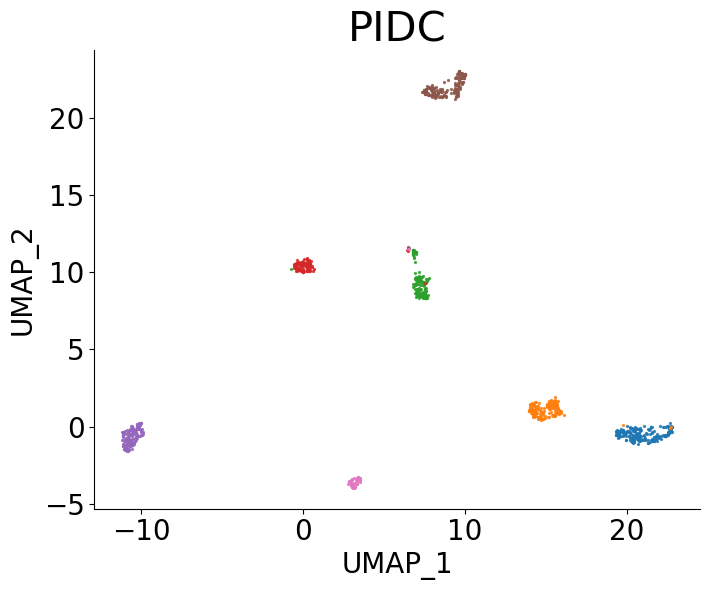

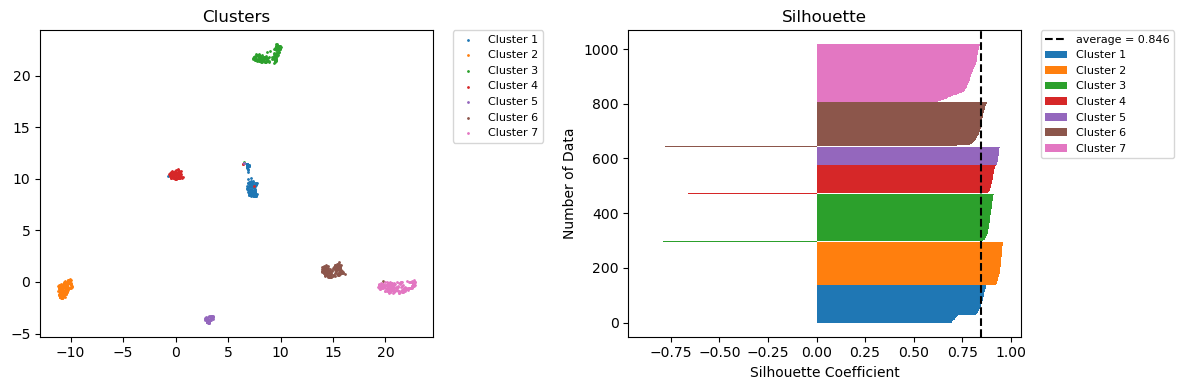

In [12]:
# PIDC

def plot_silhouette(data, clusters):
    """
    シルエット係数を計算・描画
    """
    cl_size = {}
    for c in np.unique(clusters):
        cl_size[c] = np.count_nonzero(clusters == c)
    silhouette = calc_silhouette(data, clusters)
    silhouette_ave = np.average(silhouette)
    ids_sorted = np.lexsort((silhouette, clusters))
    data_sorted = data[ids_sorted]
    silhouette_sorted = silhouette[ids_sorted]
    
    plt.figure(figsize=(12, 4))
    # クラスタの描画
    plt.subplot(1, 2, 1)
    plt.title('Clusters')
    start = 0
    for c in range(len(cl_size)):
        plt.scatter(data_sorted[start:start+cl_size[c], 0], data_sorted[start:start+cl_size[c], 1], s=1.0, label='Cluster {}'.format(c+1))
        start += cl_size[c]
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8)
    plt.tight_layout()
    # シルエット図の描画
    plt.subplot(1, 2, 2)
    plt.title('Silhouette')
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Number of Data')
    plt.axvline(silhouette_ave, c='black', linestyle='dashed', label='average = {:.3f}'.format(silhouette_ave))
    start = 0
    for c in range(len(cl_size)):
        plt.barh(range(start, start+cl_size[c]), silhouette_sorted[start:start+cl_size[c]], height=1.0, label='Cluster {}'.format(c+1))
        start += cl_size[c]
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8)
    plt.tight_layout()
    plt.savefig('figures/SVD-UMAP_HumanES_Chu_PIDC_merge_ratio_p1000_40c_50n_silhouette_5.png')
    plt.show()

#!/usr/bin/env python
# -*- coding: utf-8 -*-
# 主成分分析(PCA)→tSNE を行うプログラム

import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import umap.umap_ as umap
from scipy.sparse.csgraph import connected_components
from sklearn import datasets
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import seaborn as sns
import csv
import os
import collections 
import silhouette


def main():
   
    labels = []
    #input_data1 = pd.read_csv("HumanES_EEI_feature_ratio_matrix_5000pair.csv", index_col=0)
    #input_data1 = pd.read_csv("GSE76381_ESMoleculeCounts.cef.txt", index_col=0, sep="\t")
    input_data1 = pd.read_csv("Data_2021_NatsuNakajima/FigS2/A/raw/HumanES_Chu_PIDC_feature_merge_matrix_1000pair.csv", index_col=0)
    labels = input_data1.columns
    COL = np.array(labels)
    print(len(COL))
    A = pd.Series(COL)
    DEL = A.str.strip("_"".""0""1""2""3""4""5""6""7""8""9")

    input_data1.columns = DEL
    DEL_list = DEL.values.tolist()
    print(len(DEL_list))
    DEL_string = " ".join(DEL_list)
    DEL_unique = list(set(DEL_list))
    print(DEL_unique)
    count = 0
    for d in DEL_unique:
       DEL_string = DEL_string.replace(d, str(count))
       count += 1
       
    DEL_num = DEL_string.split(' ')
    print(len(DEL_num))
    DEL_num = [int(s) for s in DEL_num]
    DEL_num = np.array(DEL_num)
    
    #print(input_data1.columns)
    NEW_A = np.array(input_data1)
    Allgene = NEW_A.shape[0]
    Allsample = NEW_A.shape[1]
    print(NEW_A.shape)

     # Normalizationを行う
    
    #Norm_read = np.zeros((Allgene, Allsample), dtype=np.float64)
    #sum_UMI = []
    #for s in range(0, Allsample):
    #   sum_umi = 0.0
    #   for i in range(0, Allgene):
    #      sum_umi += float(NEW_A[i][s])
    #   sum_UMI.append(sum_umi)
       #print (sum_UMI[s])

    #for s in range(0, Allsample):
    #   for i in range(0, Allgene):
    #      Norm_read[i][s] = (float(NEW_A[i][s]) / sum_UMI[s])*10000
    #print (Norm_read[i][s])         

    #Log_A = np.log1p(Norm_read)
    #Log_A = np.log1p(NEW_A)
    #print(Log_A)
   
    # 主成分分析する
    #pca = PCA(n_components=20)
    #pca.fit(NEW_A.T)
    # 分析結果を元にデータセットを主成分に変換する
    #transformed = pca.fit_transform(NEW_A.T)

    # perform SVD
    model_svd = TruncatedSVD(n_components=40)
    vecs_list = model_svd.fit_transform(NEW_A.T)

    # 削減した10次元データを、さらにtSNEにかけてみる
    #model = TSNE(n_components=2, perplexity=20, n_iter=20000, verbose=1, random_state=10)
    #tsne = model.fit_transform(transformed)
    #tsne = model.fit_transform(vecs_list)

    # Perform UMAP for 20-dimensitonal data
    model_umap = umap.UMAP(n_components=2,n_neighbors=50)
    UMAP = model_umap.fit_transform(vecs_list)
    #print(DEL_list)
    
    df = pd.DataFrame({ 'UMAP_1' : UMAP[:,0], 'UMAP_2' : UMAP[:,1], 'cell' : input_data1.columns})
    df.head()

    #sns.lmplot(x="tSNE_1", y="tSNE_2", data=df, hue="cell", fit_reg=False, legend=True, markers=".", size=5)
    #sns.lmplot(x="UMAP_1", y="UMAP_2", data=df, hue="cell", fit_reg=False, legend=True, scatter_kws={"marker": ".", "s": 0.8})
    sns.lmplot(x="UMAP_1", y="UMAP_2", data=df, hue='cell', fit_reg=False, legend=False, scatter_kws={"marker": ".", "s": 1.8}, height=6, aspect=1.2)
    ax = plt.gca()
    #ax.legend(title_fontsize=13,markerscale=4,title="cell", fontsize=10, loc="best")
    ax.set_title("PIDC", fontsize=30)
    xl = ax.get_xlabel()
    ax.set_xlabel(xl, fontsize=20)
    yl = ax.get_ylabel()
    ax.set_ylabel(yl, fontsize=20)
    ax.tick_params(labelsize=20)
    plt.tight_layout()
    plt.savefig('figures/SVD-UMAP_HumanES_Chu_PIDC_merge_ratio_p1000_40c_50n.png')
    
    #silhouette.plot_silhouette(UMAP, DEL_num)
    plot_silhouette(UMAP, DEL_num)


    # 主成分の寄与率を出力する
    #print('各次元の寄与率: {0}'.format(pca.explained_variance_ratio_))
    #print('累積寄与率: {0}'.format(sum(pca.explained_variance_ratio_)))
    
         # グラフを表示して保存
    #plt.savefig('PCA-tSNE_human_ES_EEI_ratio_feature.png')
    #plt.savefig('SVD-UMAP_human_ES_EEI_ratio_feature_5000pair_40c_50n.png')
    #plt.savefig('SVD-UMAP_human_ES_raw_40c_50n.png')
    #plt.savefig('SVD-UMAP_HumanES_Manno_EEI_merge_ratio_p1000_40c_50n.png')
    #plt.show()



if __name__ == '__main__':
    main()